In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from IPython.display import Audio


In [ ]:
def get_signal(frequency,sample_rate,length):
  # w=2piF
  # sample rate is number of distinct  points taken in one second from  a continous wave
  sample=list(np.linspace(0,2*np.pi*frequency,sample_rate))
  ts= np.sin(sample*length)
  return ts


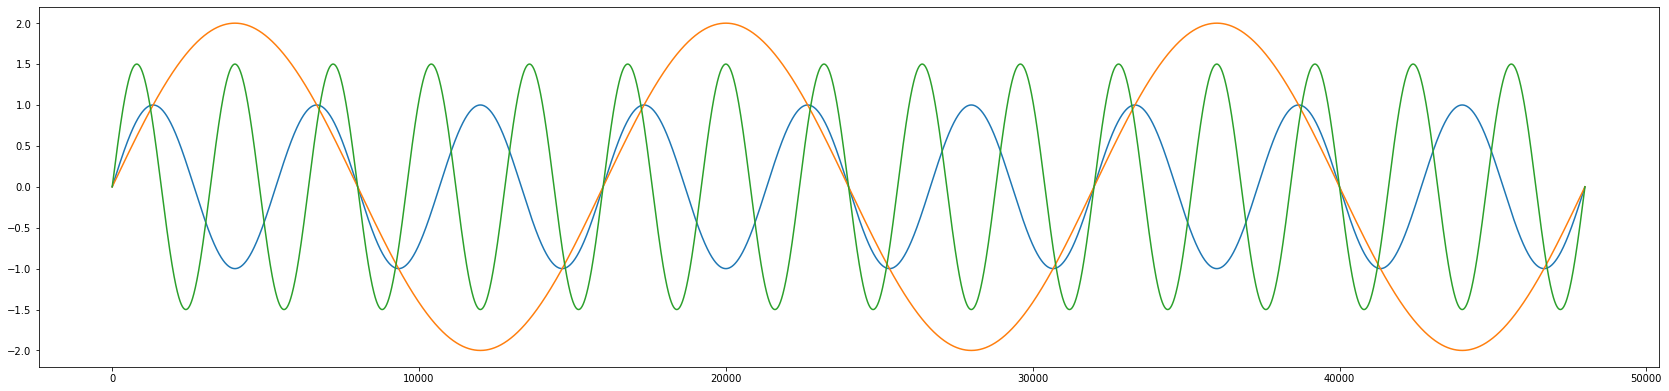

In [ ]:
f1=3
f2=1
f3=5
sr=16000

aud1=get_signal(f1,sr,3)
aud2=get_signal(f2,sr,3)*2
aud3=get_signal(f3,sr,3)*1.5
fig =  plt.figure(figsize=(25, 25))
ax = fig.add_axes([1, 2, 0.9, 0.2])

ax.plot(aud1)
ax.plot(aud2)
ax.plot(aud3)


# both the frequencies in time domain

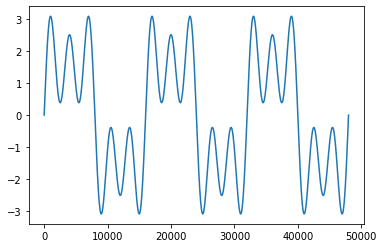

In [ ]:
#if we add them
aud=aud1+aud2+aud3
plt.plot(aud)


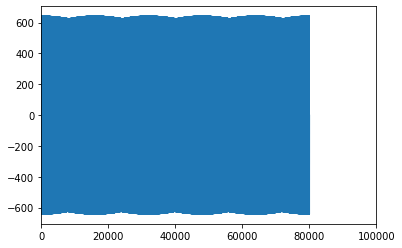

In [ ]:
sr=16000

f1=500
f2=1000
f3=2000

aud1=get_signal(f1,sr,5)*400
aud2=get_signal(f2,sr,5)*300
aud3=get_signal(f3,sr,5)*200

aud=aud1+aud2+aud3
plt.xlim(0,100000)
plt.plot(aud)

In [ ]:
Audio(aud, rate=sr)


the audio is visualised in tme domain so we know the amplitude wiht respepct to time but we don not know whuch frequency has which amplitude
so converting it to frequency domain with help of fourier transform

**FOURIER TRANSFORM**

N is the total number of samples

k  => 0,1...N-1

n  -> 0,1,..N-1




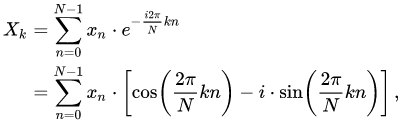

Frequency Bins represent range of the frequency histograms
the difference between two consecutive grequency will [ be sample rate/No samples]  
so frequency =k(frequenct bin value) *sampling rate/Total sample (N)

**Two Sided Frequency Plot**

The frequency axis is identical to that of the two-sided power spectrum


The two-sided amplitude spectrum actually shows half the peak amplitude at the positive and negative frequencies.
 To convert to the single-sided form, multiply each frequency other than DC by two, and discard the second half of the array.




 It is impossible to major the frequencies above **Nyquest Limit = sample rate / 2**

So **ignore the frequency bins above Nyquest Limit and *`double`* the values below Nyquest Limit**


 **Amplitude =Magnitude/N** averaging

Fourier coefficients will be in the for A+B



 Magnitude  =  sqrt((A)2+(B)2)

 coeff*2  Nyquest limit
 

 
**Magnitude=abs(B)   **


**Short-Time Fourier Transform **

So after the dft we have the frequency components with their amplitude
but it is only static we do not have information of time

but audio data is Dynamic
we do not know at what time which frequenct has waht amt of amplitude

**we know what but don't know when**

***Idea :***

Instead of passing the discrete sample for the whole duration of time (say 10 sec) we pass frame by frame to dft where each frame corresponds to a timeframe(say 2sec to 3secs) 

we get a frequency spectrum of the fram sliding through the time stamps

**Overlap:**

if the shift between two consecutive frames is equal to the frame size then there is no overlap
so the overlap quantity is no of points overlap between two consecutive frame (i.e shift =frame-overlap)


Finally the absolute values of Spectrogram is rescaled to have better color code the magnitudes.
**10log10(|Xk|)**

In [ ]:
class Spectrogram():
  def __init__(self,audio,sample_rate):
    self.audio_sample=audio
    self.sr=sample_rate
  def dft_coeff(self,X,k):
    """
    Input X,k  where X is the discrete samples taken from the sample waveX
               k is kth frequency bin 
    Output  :Fourier coefficient for kth frequency bin
    Procedure : using the above formula
    """

    N=len(X)
    n=np.arange(0,N,1)# n is from 0 to N-1
    Xk=np.sum(X*(np.exp((1j*2*np.pi*k*n)/N))) # X is a vector of discrete samples   adn n is from 0 to N-1
    #print(k,Xk,np.abs(Xk),np.abs(Xk)*2/N)
    return Xk
  def Dft(self,Xn):
    """
    Input : Discrete time samples
    Output : fourier coefficient of all frequency bins upto Nyquest limit
    It is impossible to major the frequencies above Nyquest Limit = sample rate / 2
    Procedure : k ==>0,1,2..N/2(Nyquest limit)
    """
    Amplitude=[]
    N=len(Xn)
    for k in range(int(N/2)): #  Nyquest Limit 
      coeff_k=self.dft_coeff(Xn,k)*2 # since Nyquest limit we are doubling the values

      Magnitude=np.abs(coeff_k) # abs =sqrt(A^2+B^2)
      Amplitude.append(Magnitude/N)
    return Amplitude
  

      

      

  def Dft_fast(self,Xn): 
    from scipy.fftpack import fft
    N=len(Xn)
    frequency = np.linspace (0.0, 512, int (N/2))

    freq_data = fft(Xn)
    y = 2/N * np.abs (freq_data [0:np.int (N/2)])
    return y

  def plot_spec(self,spec) :
    N=len(self.audio_sample)
    ks   = np.linspace(0,N,10) 
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(spec,origin='lower')

    Nyticks = 10
    ks      = np.linspace(0,spec.shape[0],Nyticks)
    ksHz    = self.frequncy_scale(N)
    plt.yticks(ks,ksHz)
    plt.ylabel("Frequency (Hz)")

    Nxticks = 10
    ts_spec = np.linspace(0,spec.shape[1],Nxticks)
    ts_spec_sec  = ["{:4.2f}".format(i) for i in np.linspace(0,1000,Nxticks)]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Spectrogram L={} Spectrogram.shape={}".format(self.fs,spec.shape))
    plt.colorbar(use_gridspec=True)
    plt.show()


  def Spectrogram(self,Discrete_Samples,frame_Size,overlap=None):
    """
    Input : Discrete time samples
    window size :no of points to be in the block
    overlap: if the shift of window per time stamp is less than windowsize then we have the overlap
   
    Output : A spectrogram which represent amplitude of frequency in all time range
    Procedure : A Window which slides through the time domain calling the Dft function so we get the frequency and its corresponding amplitude
    in that way we get freqand amp for all time ranges
    """
    if(overlap==None):
      overlap=int(frame_Size/2)
    N=len(Discrete_Samples)
    shift=frame_Size-overlap
    self.fs=frame_Size
    frame_starts=np.arange(0,N-frame_Size,shift)
    outputs=[]
    for s in frame_starts:
      outputs.append(self.Dft_fast(Discrete_Samples[s:s+frame_Size]))

      
    specX = np.array((outputs)).T
    spec  = 10*np.log10(specX) #convert amplitude to decibal
    self.spec_starts= frame_starts 
    return spec



  def frequncy_scale(self,sample_len):
    """
    input : list of amplitude's where index represent the frequency bin
    Output :list of amplitude where incex represent the corresponding frequency
    Procedure:freq=sr*frequencybin/N

    """
    N=sample_len
    ks   = np.linspace(0,N,10)

    freq_Hz = ks*self.sr/N
    freq_Hz  = [int(i) for i in freq_Hz ] 
    return freq_Hz 




In [ ]:
x=Spectrogram(aud,sr)
print(len(aud),sr)
plot=x.Dft_fast(aud)


80000 16000


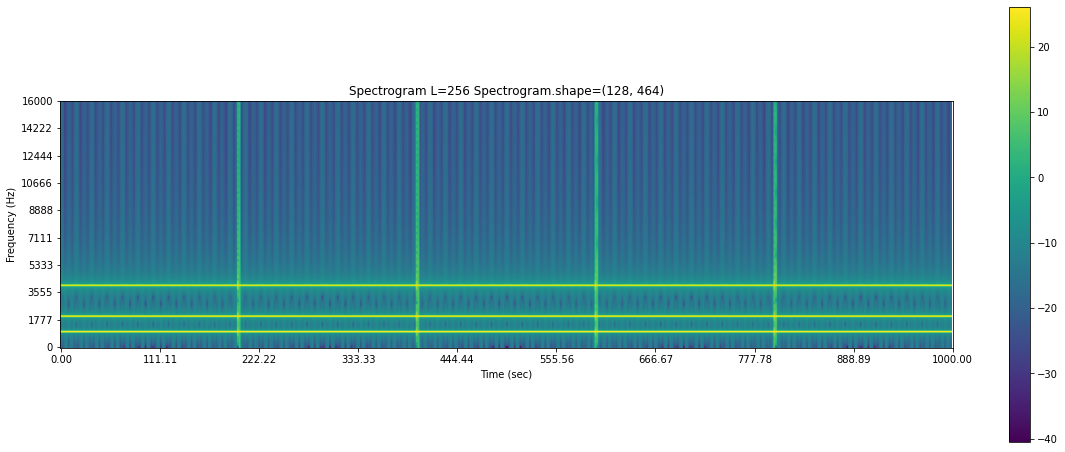

In [ ]:
spec=x.Spectrogram(aud,256,84)

x.plot_spec(spec)


In [ ]:
print([[i,n/len(aud)*sr] for n,i in enumerate(plot) if i >30])

[[399.37616238668664, 500.0], [298.04871910360475, 1000.0], [194.85269637679727, 2000.0]]


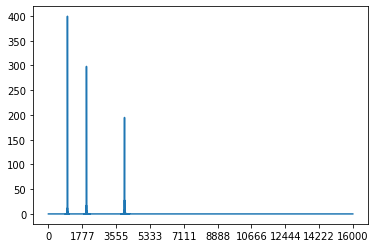

In [ ]:
plt.xticks(np.linspace(0,len(plot),10),freq)
plt.plot(plot)

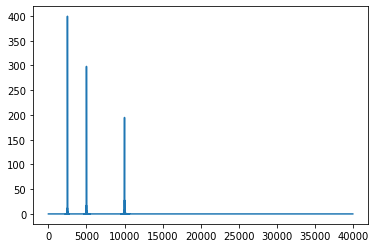

In [ ]:
from scipy.fftpack import fft
N=len(aud)
frequency = np.linspace (0.0, 512, int (N/2))

freq_data = fft(aud)
y = 2/N * np.abs (freq_data [0:np.int (N/2)])
plt.plot(y)

Drawback with frequency

In [ ]:
x1=get_signal(200,sr,1)
x2=get_signal(250,sr,1)

y1=get_signal(1000,sr,1)
y2=get_signal(1050,sr,1)

Audio(x1,rate=sr)

In [ ]:
Audio(x2,rate=sr)

In [ ]:
Audio(y1,rate=sr)

In [ ]:
Audio(y2,rate=sr)

The difference in x1 x2 and y1 y2 are same mathematically (50 hz)
but while hearing it (perceptually) the diiference is pitch is varying

because frequency is lograthimi not linear so difference between two frequency at same intervals and different time period  will not be same for log scale

so to view in linear fashion we are going to change the frequency scale 

**MEl scale**